In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train_data.csv
/kaggle/input/titanic/test_data.csv


# Input of training data from input folder 
Links - https://www.kaggle.com/azeembootwala/titanic

In [2]:
input_ads = pd.read_csv('../input/titanic/train_data.csv')
input_ads.drop(columns=['Unnamed: 0','Title_1','Title_2','Title_3','Title_4'],inplace=True) #Dropping un-necessary columns
#-----------------------------------------------------------------
print(input_ads.shape)
input_ads.head()

(792, 12)


,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Emb_1,Emb_2,Emb_3
0,1,0,1,0.2750,0.014151,0,0,1,0.1,0,0,1
1,2,1,0,0.4750,0.139136,1,0,0,0.1,1,0,0
2,3,1,0,0.3250,0.015469,0,0,1,0.0,0,0,1
3,4,1,0,0.4375,0.103644,1,0,0,0.1,0,0,1
4,5,0,1,0.4375,0.015713,0,0,1,0.0,0,0,1


# Null Check

In [3]:
pd.DataFrame(input_ads.isnull().sum()).T

,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Emb_1,Emb_2,Emb_3
0,0,0,0,0,0,0,0,0,0,0,0,0


# Describe of the whole data

In [4]:
input_ads.describe()

,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Emb_1,Emb_2,Emb_3
count,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000
mean,396.500000,0.386364,0.647727,0.368244,0.064677,0.243687,0.208333,0.547980,0.088636,0.185606,0.092172,0.720960
std,228.774999,0.487223,0.477980,0.162994,0.100987,0.429577,0.406373,0.498007,0.154485,0.389034,0.289451,0.448811
min,1.000000,0.000000,0.000000,0.008375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,198.750000,0.000000,0.000000,0.275000,0.015469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,396.500000,0.000000,1.000000,0.350000,0.028302,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,594.250000,1.000000,1.000000,0.437500,0.061045,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,1.000000
max,792.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Note - The data is already standardized since it is imported from a pre-processed public dataset

In [5]:
#Total survived vs not-survived split in the training data
input_ads['Survived'].value_counts()

0    486
1    306
Name: Survived, dtype: int64

# Data Splitting & Pre-Processing 

In [6]:
target = 'Survived' #To predict

#--------------------------------------------------------------------------------
#Splitting into X & Y datasets (supervised training)
X = input_ads[[cols for cols in list(input_ads.columns) if target not in cols]]
y = input_ads[target]

#--------------------------------------------------------------------------------
#Since test data is already placed in the input folder separately, we will just import it
test_ads = pd.read_csv('../input/titanic/test_data.csv')
test_ads.drop(columns=['Unnamed: 0','Title_1','Title_2','Title_3','Title_4'],inplace=True) #Dropping un-necessary columns

#Splitting into X & Y datasets (supervised training)
X_test = test_ads[[cols for cols in list(test_ads.columns) if target not in cols]]
y_test = test_ads[target]

print('Train % of total data:',100 * X.shape[0]/(X.shape[0] + X_test.shape[0]))
#--------------------------------------------------------------------------------
#Manipulation of datasets for convenience and consistency
X_arr = np.array(X)
X_test_arr = np.array(X_test)

y_arr = np.array(y).reshape(X_arr.shape[0],1)
y_test_arr = np.array(y_test).reshape(X_test_arr.shape[0],1)

#--------------------------------------------------------------------------------
#Basic Summary
print(X_arr.shape)
print(X_test_arr.shape)
print(y_arr.shape)

Train % of total data: 88.78923766816143
(792, 11)
(100, 11)
(792, 1)


# Logistic Regression from scratch

### Defining fwd prop UDF, Cost function UDF & initiating weights and intercepts

In [7]:
#Sigmoid function for the forward propagation as well as backward propagation
def sigmoid(arr):
    
    sig = 1/(1 + np.exp(-arr))
    
    return sig

#Fn for forward propagation of the model (to caculate the predictions)
#--------------------------------------------------------------------------
def fwd_prop(X_arr,w,b):
    
    a = np.dot(X_arr,w) + b
    sig_a = sigmoid(a)
    #print('Shape of a:',a.shape)
    
    return sig_a

#Fn to calculate cost for logistic regression
#--------------------------------------------------------------------------------------------------
def cost_fn(y_true,y_pred,n_examples,reg_alpha,reg_type,w_):
    
    #Applying regularizations
    if reg_type=='L1':
        reg = np.sum(abs(w_))
    elif reg_type=='L2':
        reg = 0.5 * np.sum(np.square(w_))
    
    cost = (-1/n_examples) * np.sum((y_true * np.log(y_pred)) + ((1-y_true) * np.log(1 - y_pred))) + (reg_alpha*reg)
    
    return cost    

#Fn to convert probabilities into class 0 or 1 based on threshold
#--------------------------------------------------------------------------
def prob_to_class(arr,threshold):
    
    mask = arr>threshold
    #print(mask)
    arr_class = mask.astype(int)
    
    return arr_class


#Initiating the weight and intercept vectors with appropriate dimensions
#--------------------------------------------------------------------------
np.random.seed(100) #Setting seed for consistency in case of random number generation 

#Weights
#----------------------------------
w = np.zeros((X.shape[1],1))
print(X_arr.shape[1])
print(w.shape)
print(w)

#Intercept
#----------------------------------
b = np.zeros(1)
b

#Testing the forward propagation function
#----------------------------------
a = fwd_prop(X_arr,w,b)
a.shape

11
(11, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


(792, 1)

### UDF for batch_gradient_descent
#### 1. If batch_size=1, it becomes stochastic gradient descent

In [8]:
def batch_gradient_descent(y_arr_overall,X_arr_overall,w_,b_,n_iters=10,lr=0.01,batch_size=1,reg_alpha=1,reg_type='L2'):
    
    print('Total training rows :',X_arr_overall.shape[0])
    
    #----------------------------------------------------------------------------------------
    #Creating x-y batches according to the provided batch_size
    
    n_batches = X.shape[0]//batch_size
    print('Total Batches to create in each epoch/iter :',n_batches)
    
    batches_x = np.array_split(X_arr_overall,n_batches)
    print('Total Batches of X:',len(batches_x))

    batches_y = np.array_split(y_arr,n_batches)
    print('Total Batches of y:',len(batches_y))
    
    cost_history = [] #Cache for cost function o/p at necessary intervals for plotting later

    #----------------------------------------------------------------------------------------
    for i in range(n_iters): #Total iterations/epochs to train on
        
        if i%1000==0:
            print('#-------------------- Epoch number :',i,'--------------------#')
        
        for j in range(len(batches_x)): #For each batch created for each epoch/iter
            
            #print('Batch No :',j)
            
            X_arr_ = batches_x[j]
            y_arr_ = batches_y[j]

            n_examples = X_arr_.shape[0]
            #print(n_examples)
            #----------------------------------------------------------------------------------------
            #Forward propagation of the model - calculation of the model prediction
            a_temp = fwd_prop(X_arr_,w_,b_)

            cost = cost_fn(y_arr_,a_temp,n_examples,reg_alpha,reg_type,w_)
            
            if cost == np.inf:
                print('---- Inf encountered due to exploding gradients ----')
                return w_,b_,cost_history

            #----------------------------------------------------------------------------------------
            
            if reg_type=='L1':
                
                reg_derivative = np.divide(w_, abs(w_), out=np.zeros_like(w_), where=abs(w_)!=0)
                reg_derivative = np.where(reg_derivative==np.inf,0,reg_derivative)
                
            elif reg_type=='L2':
                
                reg_derivative = w_
            
            #Calculating the gradients for the current batch
            dz = (1/n_examples) * ((a_temp-y_arr_))  #Derivative of Loss fn 'L'(binary crossentropy) wrt z = wx+b
            
            dw = np.dot(X_arr_.T,dz) + ((1/n_examples)*(reg_alpha * reg_derivative)) #Derivative of w (weights) wrt 'L' (Applying chain rule of differentiation)
            db = (1/n_examples) * np.sum(dz) #Derivative of b (intercept) wrt 'L' (Applying chain rule of differentiation)
            
            #Updating the weight and the intercept
            w_ = w_ - (lr * dw)
            b_ = b_ - (lr * db)
        
        #Updating cost into the cache
        cost_history = cost_history + [cost]
        
        #-------------------------------------------------
        #Progress at regular intervals
        if (i%5000==0):
            print(i,': Cost ------->',cost)
            
            f_train_a = fwd_prop(X_arr_overall,w_,b_) #Results on whole training data after every 5k epochs
            #print(f_train_a.shape)
            
            f_train_a = prob_to_class(arr=f_train_a,threshold=0.5)
            print(f_train_a.shape)
            #print(y_arr_overall.shape)
            
            print('ROC AUC of training set :',roc_auc_score(y_arr_overall,f_train_a))
            print('Accuracy of training set :',accuracy_score(y_arr_overall,f_train_a))
        
    return w_,b_,cost_history

### Training the logistic regression model

In [9]:
#Training the model on the training data with the below training specs
#-----------------------------------------------------------------------------------------------------------------------
epochs = 20001
learning_rate=0.00006
batch_size_=50

#-----------------------------------------------------------------------------------------------------------------------
w_final,b_final,cost_history = batch_gradient_descent(y_arr_overall=y_arr,       #Train y array 
                                                      X_arr_overall=X_arr,       #Train X array
                                                      w_=w,                      #Passing zero initiated weight vector
                                                      b_=b,                      #Passing zero initiaed intercept vector
                                                      n_iters=epochs,            #Total epochs/iters for Gradient Descent
                                                      lr=learning_rate,          #Learning rate for Gradient Descent
                                                      batch_size=batch_size_,    #Batch size for Gradient Descent (1 for SGD)
                                                      reg_alpha=0.05,            #Regularization factor
                                                      reg_type='L1')             #Regularization Type
                                                      

Total training rows : 792
Total Batches to create in each epoch/iter : 15
Total Batches of X: 15
Total Batches of y: 15
#-------------------- Epoch number : 0 --------------------#
0 : Cost -------> 5.399809281843098
(792, 1)
ROC AUC of training set : 0.5
Accuracy of training set : 0.6136363636363636
#-------------------- Epoch number : 1000 --------------------#
#-------------------- Epoch number : 2000 --------------------#
#-------------------- Epoch number : 3000 --------------------#
#-------------------- Epoch number : 4000 --------------------#
#-------------------- Epoch number : 5000 --------------------#
5000 : Cost -------> 5.261802239445151
(792, 1)
ROC AUC of training set : 0.5081699346405228
Accuracy of training set : 0.6199494949494949
#-------------------- Epoch number : 6000 --------------------#
#-------------------- Epoch number : 7000 --------------------#
#-------------------- Epoch number : 8000 --------------------#
#-------------------- Epoch number : 9000 -----

### Plotting cost over epochs (Should have a sharp decrease)

[Text(0.5, 0, 'No of epochs'),
 Text(0, 0.5, 'Cost'),
 Text(0.5, 1.0, 'Cost vs Epochs - Logistic Regression')]

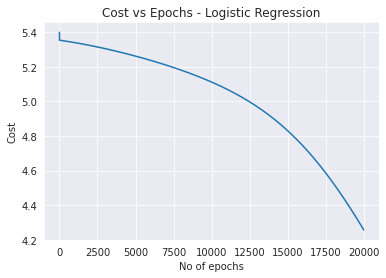

In [10]:
#Cost plot over epochs (1 value at end of each epoch) - over the last batch
sns.set_style('darkgrid')
ax = sns.lineplot(x=list(range(0,epochs)),y=cost_history)
ax.set(xlabel='No of epochs',ylabel='Cost',title='Cost vs Epochs - Logistic Regression')

### UDF for predicting

In [11]:
def predict(w_,b_,test_x,test_y):
    
    print("Testing on :",test_x.shape[0],'rows')
    
    a_temp = fwd_prop(test_x,w_,b_) #Using the weights(w_) and bias(b_) vectors derived from training 
    a_temp = prob_to_class(arr=a_temp,threshold=0.5)
    
    print('Shape of prediction :',a_temp.shape)
    
    print('ROC AUC of test set :',roc_auc_score(test_y,a_temp))
    print('Accuracy of test set :',accuracy_score(test_y,a_temp))
    
    print(a_temp[0:3])
    
    return a_temp


# Predictions from the manual created linear regression model

In [12]:
predictions_ = predict(w_final,b_final,X_test_arr,y_test_arr)

Testing on : 100 rows
Shape of prediction : (100, 1)
ROC AUC of test set : 0.5
Accuracy of test set : 0.64
[[0]
 [0]
 [0]]


# Linear Regression from sklearn as benchmark

In [13]:
from sklearn.linear_model import LogisticRegression

#---------------------------------------------------------------------------------------
log_reg = LogisticRegression(penalty='l2',random_state=100,solver='sag',max_iter=20001,tol=1e-4,C=20)
log_reg.fit(X_arr,y_arr)

prediction_sklearn = log_reg.predict(X_test_arr)

#---------------------------------------------------------------------------------------
print('ROC AUC of test set :',roc_auc_score(y_test_arr,prediction_sklearn))
print('Accuracy of test set :',accuracy_score(y_test_arr,prediction_sklearn))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ROC AUC of test set : 0.7673611111111112
Accuracy of test set : 0.78


# SGD Classifier
- (Logistic regression with normal stochastic gradient descent) - Directly comparable with manual implementation

In [14]:
from sklearn.linear_model import SGDClassifier

#---------------------------------------------------------------------------------------
log_reg_sgd = SGDClassifier(loss='log',penalty='l2',alpha=0.05,random_state=100,epsilon=learning_rate,max_iter=epochs,tol=1e-10)
log_reg_sgd.fit(X_arr,y_arr)

prediction_sklearn_sgd = log_reg_sgd.predict(X_test_arr)

#---------------------------------------------------------------------------------------
print('ROC AUC of test set :',roc_auc_score(y_test_arr,prediction_sklearn_sgd))
print('Accuracy of test set :',accuracy_score(y_test_arr,prediction_sklearn_sgd))

ROC AUC of test set : 0.5
Accuracy of test set : 0.64


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Comparison to SGD Classifier (Because, sklearn logistic regression has other optimization techniques, its not directly comparable) 

### Percent deviation in the weights (with respect to manual logistic regression weights)

In [15]:
100 * (w_final-log_reg_sgd.coef_.ravel().reshape(11,1))/w_final

array([[  26.67182702],
       [ -96.27737112],
       [ 129.21939279],
       [   4.093618  ],
       [ -10.28295667],
       [  39.61664033],
       [-228.49729974],
       [  60.95272979],
       [  15.94096093],
       [  67.70423743],
       [ 223.02321429]])

## Insights : 
1. Though the weights are very different as we see above, the models are predicting similarly.
2. This indicates that there are multiple solutions possible for the data in hand

# END